##### Turbo Jet Engine Remaining Useful Lifetime Prediction using survival model
* First, download the Turbofan Engine Degradation Simulation dataset from NASA Prognostics Center of Excellence Data Set Repository: https://www.nasa.gov/content/prognostics-center-of-excellence-data-set-repository

* Next, put downloaded train_FD001 and test_FD001 into storage/input

* Brief description about Dataset - 
    * Data sets consists of multiple multivariate time series. There are training and test data subsets.
    * The engine is operating normally at the start of each time series, and develops a fault at some point during the series. 
    * In the training set, the fault grows in magnitude until system failure. 
    * In the test set, the time series ends some time prior to system failure. 
    * The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. 

In [1]:
# Import necessary libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Get the column names
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [3]:
# Get current working directory
current_dir = os.getcwd()

In [5]:
# Read training file
file_path = os.path.join(current_dir,"storage/input/train_FD001.txt")
train_df = pd.read_csv(file_path,sep='\s+',header=None,index_col=False,names=col_names)
print('Shape of train_df: ',train_df.shape) # Print the shape of the training dataframe
print(train_df.head()) # Print out what is inside the training dataframe

Shape of train_df:  (20631, 26)
   unit_number  time_cycles  setting_1  setting_2  setting_3  sensor_1  \
0            1            1    -0.0007    -0.0004      100.0    518.67   
1            1            2     0.0019    -0.0003      100.0    518.67   
2            1            3    -0.0043     0.0003      100.0    518.67   
3            1            4     0.0007     0.0000      100.0    518.67   
4            1            5    -0.0019    -0.0002      100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  \
0    641.82   1589.70   1400.60     14.62  ...     521.66    2388.02   
1    642.15   1591.82   1403.14     14.62  ...     522.28    2388.07   
2    642.35   1587.99   1404.20     14.62  ...     522.42    2388.03   
3    642.35   1582.79   1401.87     14.62  ...     522.86    2388.08   
4    642.37   1582.85   1406.22     14.62  ...     522.19    2388.04   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0    8138.62     8.

In [6]:
# Read the test data FD001.txt
file_path = os.path.join(current_dir,"storage/input/test_FD001.txt")
test_df = pd.read_csv(file_path,sep='\s+',header=None,index_col=False,names=col_names)
print('Shape of test_df: ',test_df.shape) # Print the shape of test dataframe
print(test_df.head()) # print out what is inside the test dataframe

Shape of test_df:  (13096, 26)
   unit_number  time_cycles  setting_1  setting_2  setting_3  sensor_1  \
0            1            1     0.0023     0.0003      100.0    518.67   
1            1            2    -0.0027    -0.0003      100.0    518.67   
2            1            3     0.0003     0.0001      100.0    518.67   
3            1            4     0.0042     0.0000      100.0    518.67   
4            1            5     0.0014     0.0000      100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  \
0    643.02   1585.29   1398.21     14.62  ...     521.72    2388.03   
1    641.71   1588.45   1395.42     14.62  ...     522.16    2388.06   
2    642.46   1586.94   1401.34     14.62  ...     521.97    2388.03   
3    642.44   1584.12   1406.42     14.62  ...     521.38    2388.05   
4    642.51   1587.19   1401.92     14.62  ...     522.15    2388.03   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0    8125.55     8.4

In [7]:
def check_missingvalue(df:pd.DataFrame):
    '''
        This function will check for missing value in the input dataframe
    '''
    out = {}
    # create a Boolean mask for missing values
    missing_values = df.isnull()
    # count the number of missing values in each column
    missing_counts = missing_values.sum()
    # List down columns containing missing values
    missing_value_columns = missing_counts[missing_counts > 0].index.tolist()
    # print(missing_value_columns)
    # Get total number of missing values for each column
    if len(missing_value_columns) > 0:
        total = df.isnull().sum().sort_values(ascending = False)
        percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
        rslt_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()
        out['HasMissingValue'] = True
        out['missing_value_columns'] = missing_value_columns
        out['missing_info'] = rslt_df
    else:
        out['HasMissingValue'] = False
        out['missing_info'] = None
        out['missing_value_columns'] = None
    
    return out

In [8]:
# Check missing values in train_df
result = check_missingvalue(train_df)
print("Are there missing value in dataset: ", result['HasMissingValue'])

Are there missing value in dataset:  False


In [9]:
# Generate descriptive statistics of sensor 1 to sensor 10
train_df.loc[:,'sensor_1':'sensor_10'].describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
count,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04
mean,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.300000e+00
std,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092,0.070985,22.082880,4.660829e-13
min,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.300000e+00
25%,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.300000e+00
50%,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.300000e+00
75%,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.300000e+00
max,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.300000e+00


* From above descriptive sensor statistics data, some of the sensors data standard deviation is very small either zero or nearly zero. These sensors are sensor_1, sensor_5, and sensor_13. Therefore, those sensors will not be used in survival analysis.

In [10]:
# Generate descriptive statistics of sensor 11 to sensor 21
train_df.loc[:,'sensor_11':'sensor_21'].describe()

,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,0.267087,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


* From above descriptive sensor statistics data, some of the sensors data standard deviation is very small either zero or nearly zero. These sensors are sensor_12, sensor_16, sensor_18, and sensor_19. Therefore, those sensors will not be used in survival analysis.

In [11]:
train_df_new = train_df[['unit_number', 'setting_1',  'setting_2',  'setting_3', 'time_cycles', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']]
test_df_new = test_df[['unit_number', 'setting_1',  'setting_2',  'setting_3', 'time_cycles', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']]

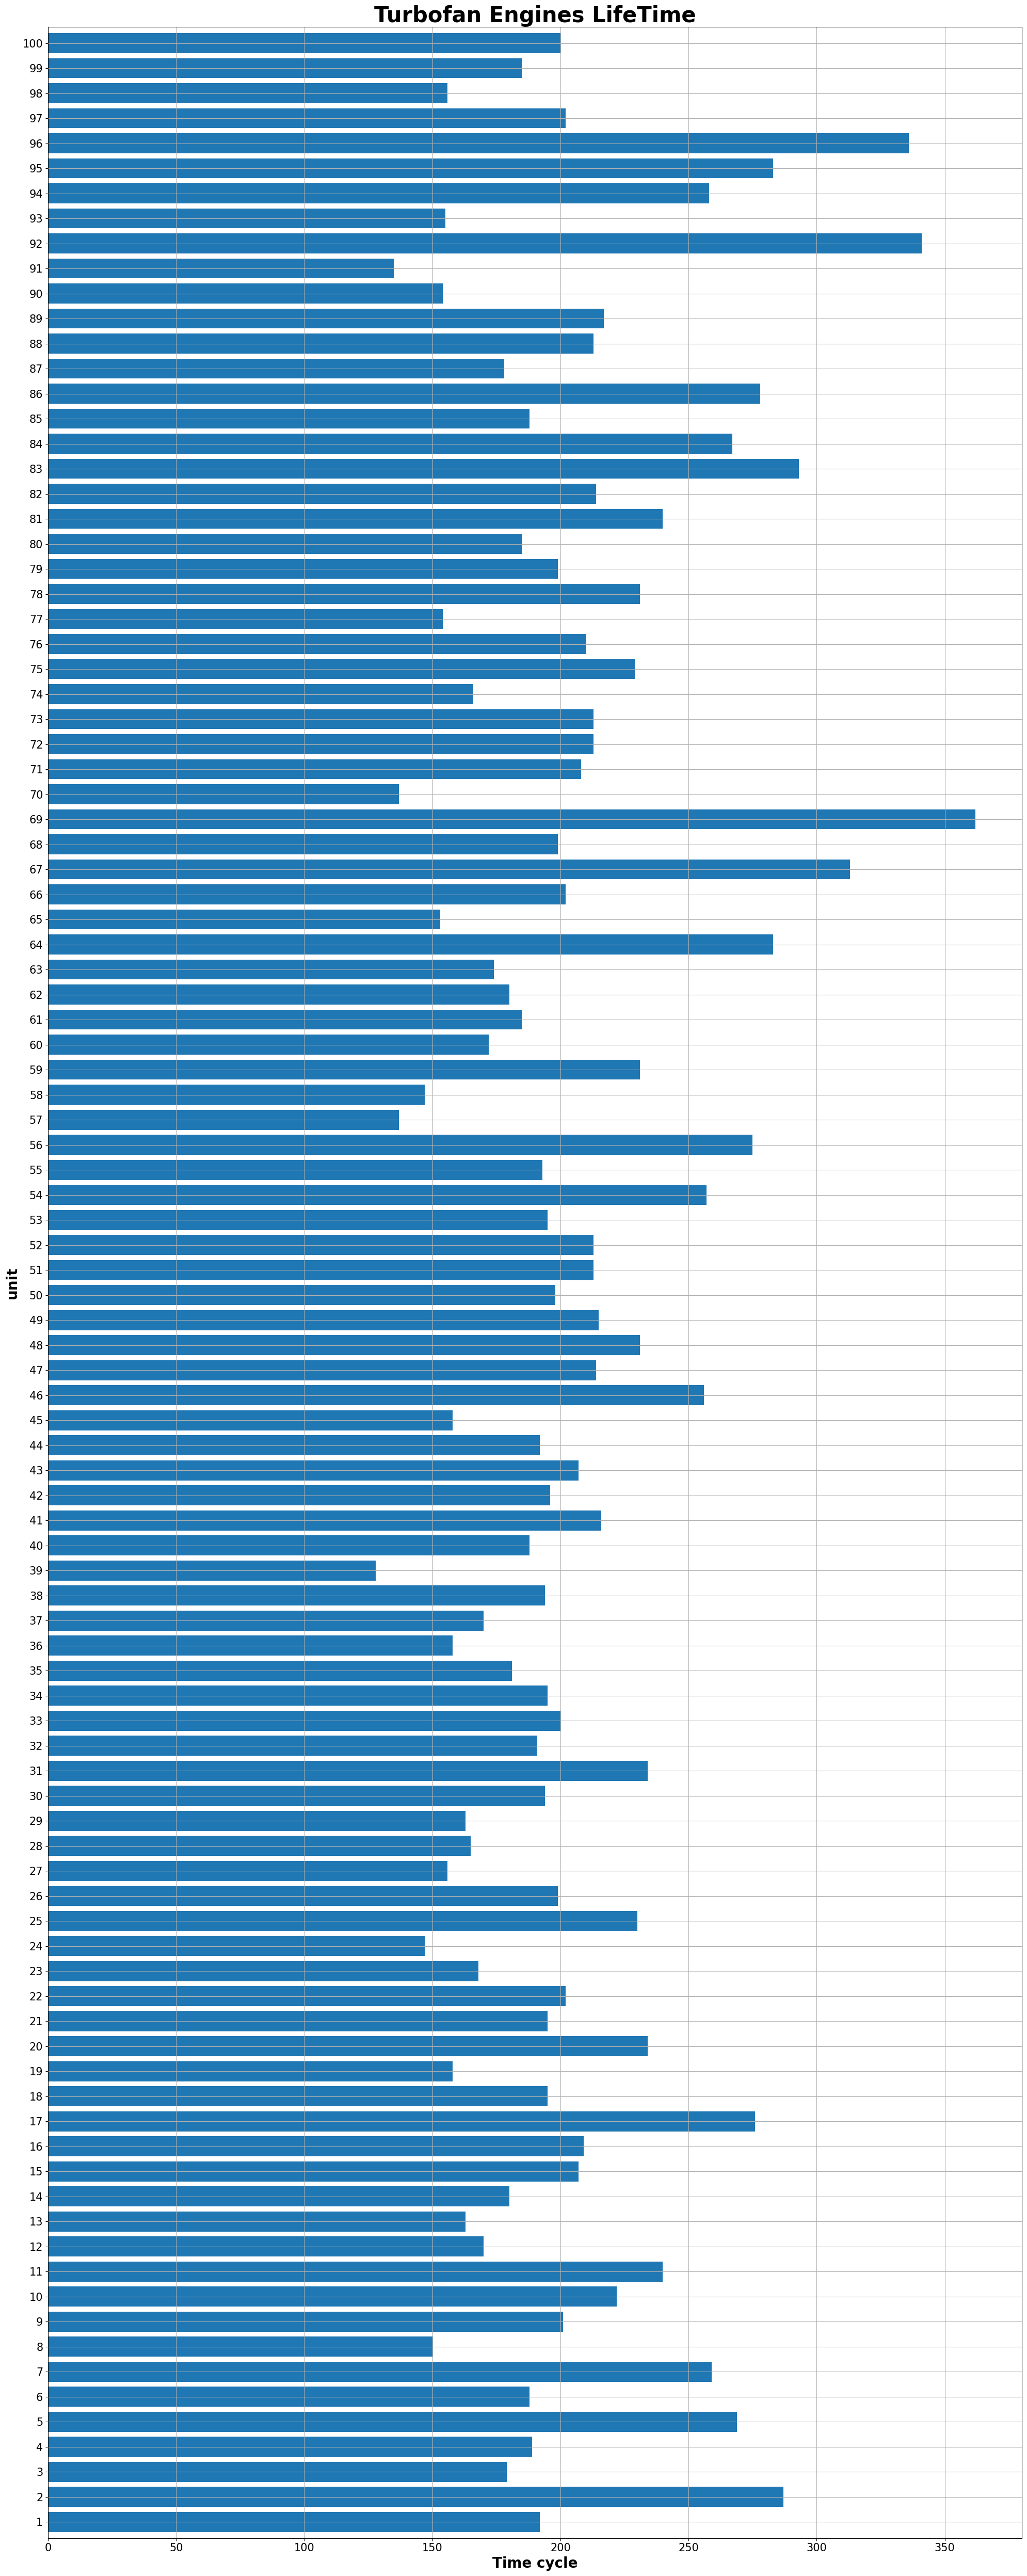

In [12]:
# Find the maximum time cycles of each unit number.
max_time_cycles=train_df[index_names].groupby('unit_number').max()

# Plot bar chart of maximum time cycles of each unit number
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

* From above time cycle bar chart, we can see that maximum time cycles of jet engine units are different. 
* Some jet engine units fails at early (e.g., unit no: 8, 14, 39, etc.) while some jet engine units fails at later state (e.g., unit no: 2, 5, 7, etc.)

#### KaplanMeier Survival Analysis
* The Kaplan-Meier curve is a graphical representation of the survival function. 
* It is a non-parametric estimate of the survival function that does not make any assumptions about the underlying distribution of the data.
* It shows the probability that the jet engine unit will survive up to time t.

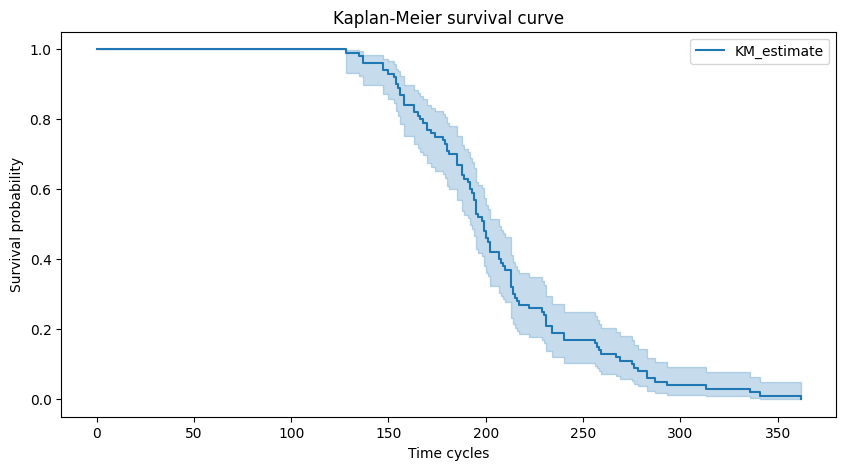

In [13]:
#KaplanMeier Fitter with censorship
kmf = KaplanMeierFitter()
# duration - how long each machine operates
T = max_time_cycles['time_cycles']
# Fit KaplanMeier fitter without censorship
kmf.fit(T)
plt.figure(figsize=(10,5))
kmf.plot_survival_function()
plt.ylabel('Survival probability')
plt.xlabel('Time cycles')
plt.title('Kaplan-Meier survival curve')
plt.show()

* From above KaplanMeier survival curve, as the operating time cycles of jet engine units increases, the probability of those units being able to survive decreases; which means that those jet engine unit will fail. When operating time cycle reaches 350 cycles, the engine unit will be estimated to be failed as probability becomes zero.

In [14]:
# Calculate remaining useful lifetime (RUL)
def calculate_rul(df):
    # group input dataframe by unit number.
    df_grouped_by_unit = df.groupby(by='unit_number') 
    # Find maximum time cycles
    max_time_cycles = df_grouped_by_unit['time_cycles'].max() 
    # Merge dataframe df and max_time_cycle.
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    # Calculate RUL = maximum time cycle of each unit - time cycles of each unit. 
    # Example, for jet engine unit 1, Max time cycle = 192. After operating first time cycle, RUL of jet engine unit 1 will be 191 cycles.
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1) 
    return merged

In [15]:
# Calculate RUL for training dataframe
xtrain = calculate_rul(train_df_new)
# Calculate RUL for test dataframe
xtest = calculate_rul(test_df_new)
# # Add censorship
# xtrain['observe'] = 0
# # Add sensorship >> engine unit time cycle >= 200 are censored.
# xtrain.loc[xtrain.time_cycles<200,'observe']=1
print(xtrain)

       unit_number  setting_1  setting_2  setting_3  time_cycles  sensor_3  \
0                1    -0.0007    -0.0004      100.0            1   1589.70   
1                1     0.0019    -0.0003      100.0            2   1591.82   
2                1    -0.0043     0.0003      100.0            3   1587.99   
3                1     0.0007     0.0000      100.0            4   1582.79   
4                1    -0.0019    -0.0002      100.0            5   1582.85   
...            ...        ...        ...        ...          ...       ...   
20626          100    -0.0004    -0.0003      100.0          196   1597.98   
20627          100    -0.0016    -0.0005      100.0          197   1604.50   
20628          100     0.0004     0.0000      100.0          198   1602.46   
20629          100    -0.0011     0.0003      100.0          199   1605.26   
20630          100    -0.0032    -0.0005      100.0          200   1600.38   

       sensor_4  sensor_7  sensor_8  sensor_9  sensor_11  senso

<AxesSubplot:>

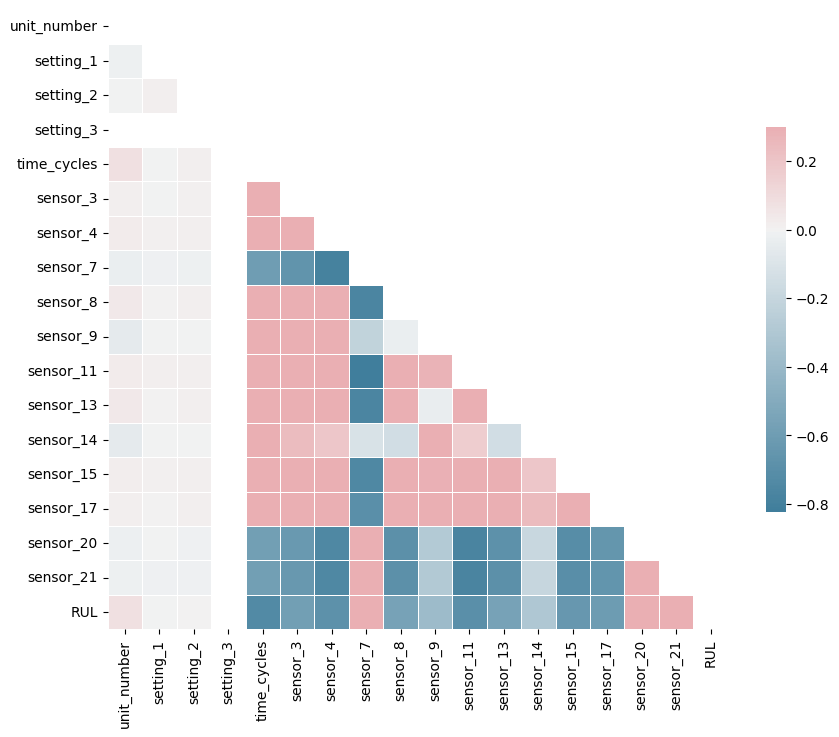

In [16]:
# Discovering Correlations
# Compute the correlation matrix
corr = xtrain.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

* From above correlation heatmap, some sensor values have negative correlation with RUL (e.g., sensor3, sensor4) while some sensor values have positive correlation with RUL (e.g., sensor20, sensor21).

* Now, lets visualize those sensor measurements with RUL

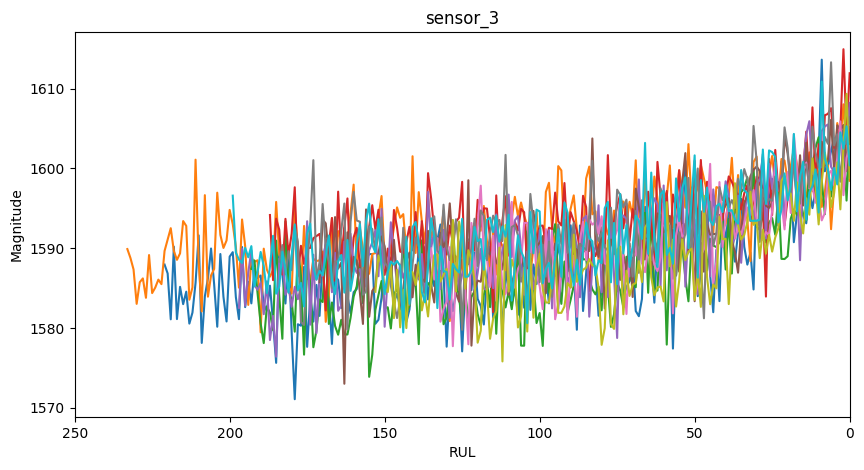

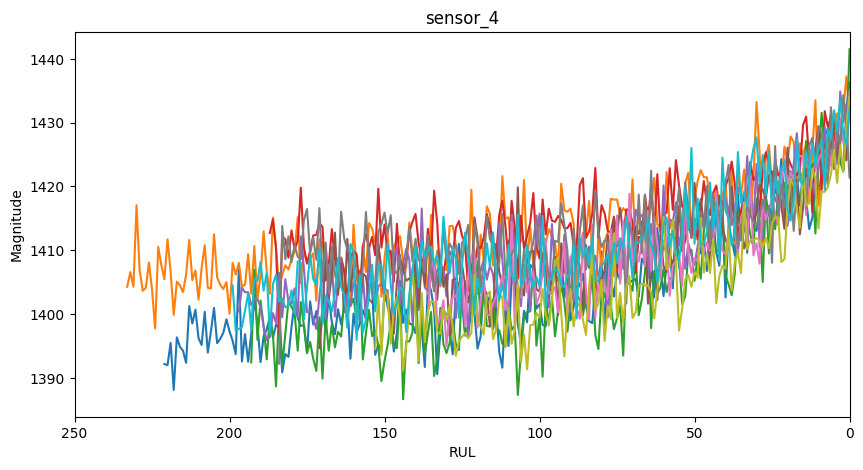

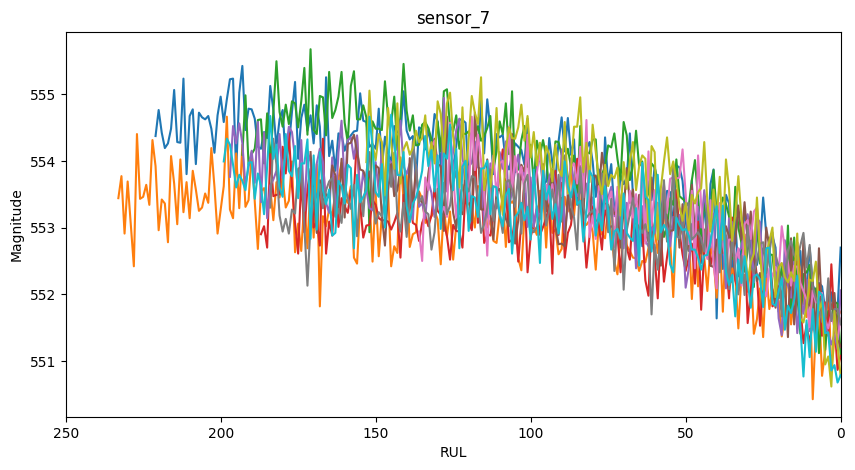

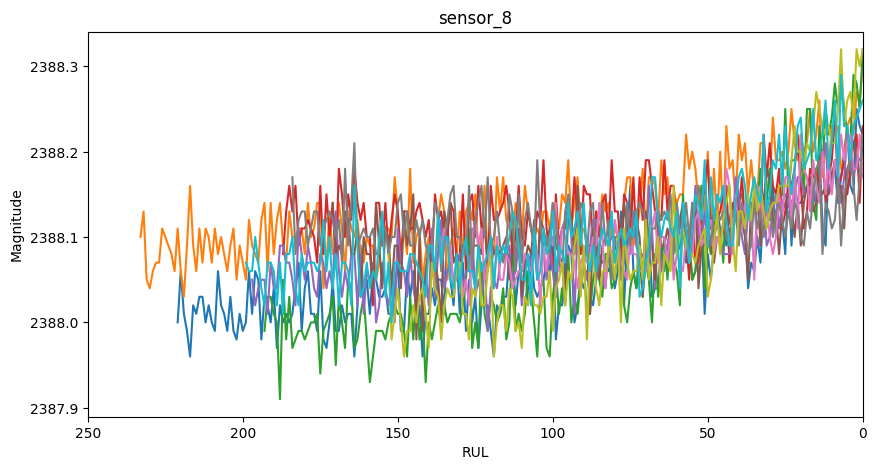

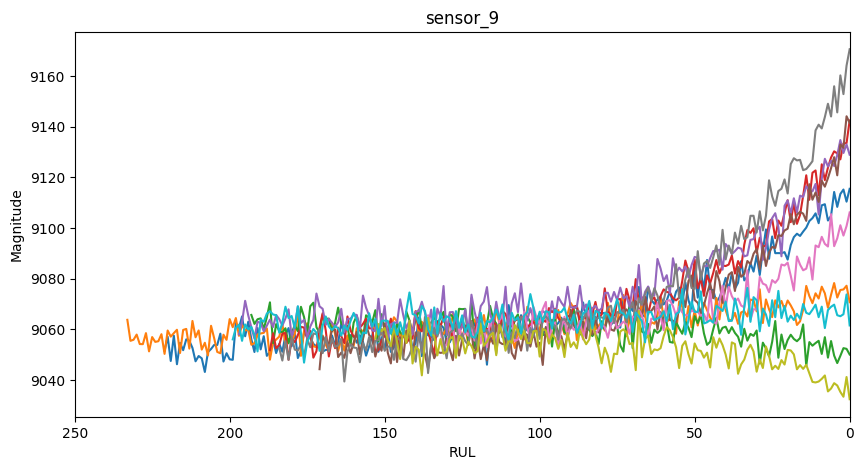

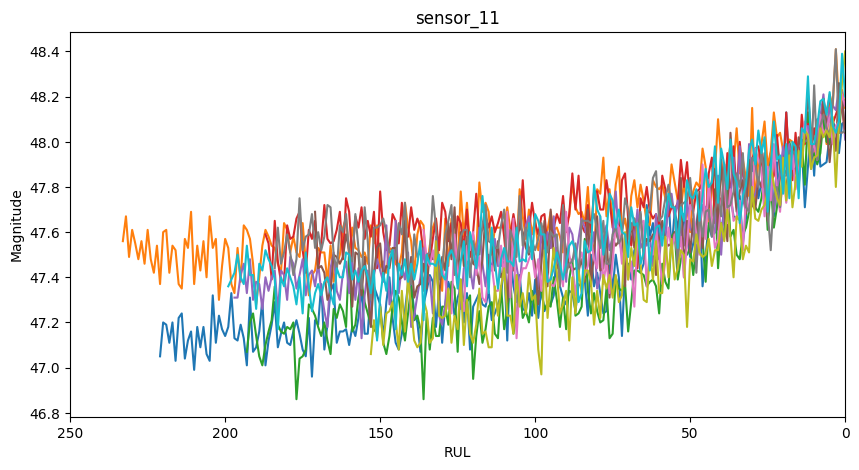

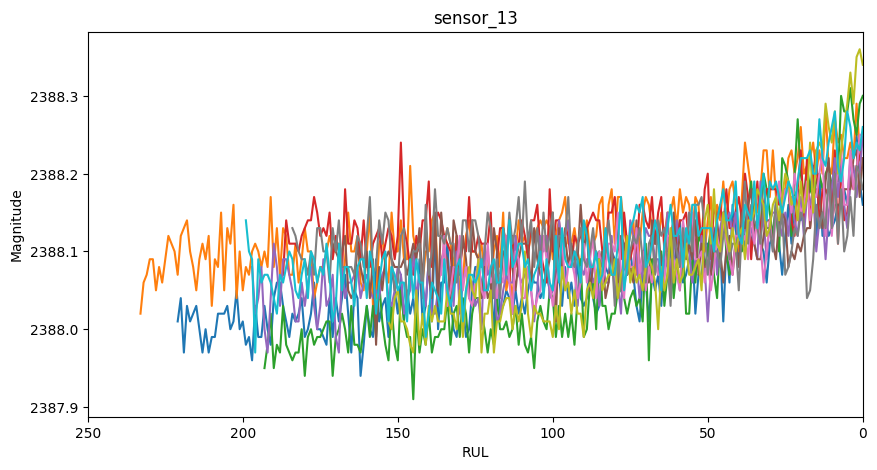

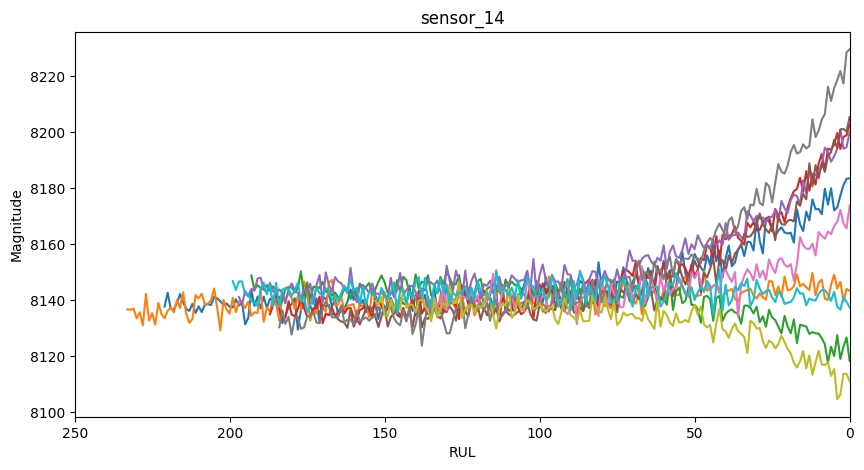

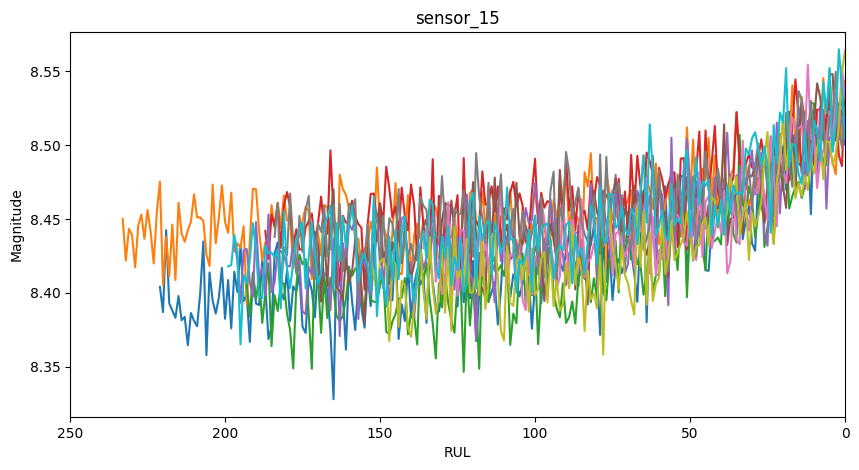

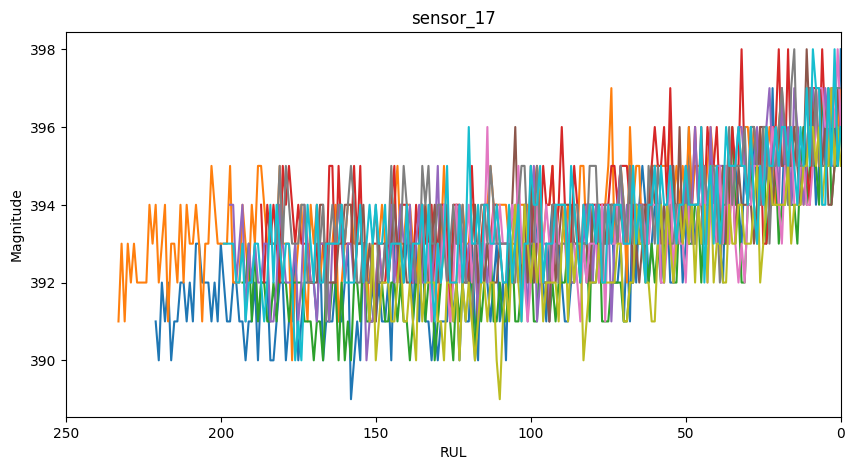

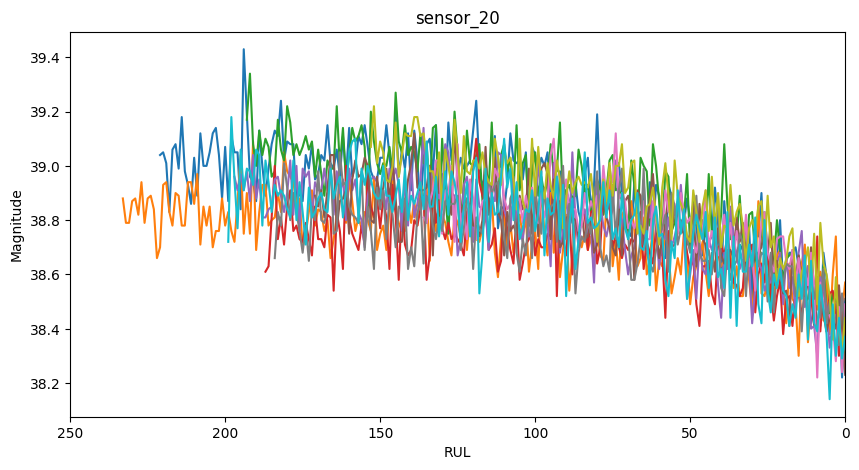

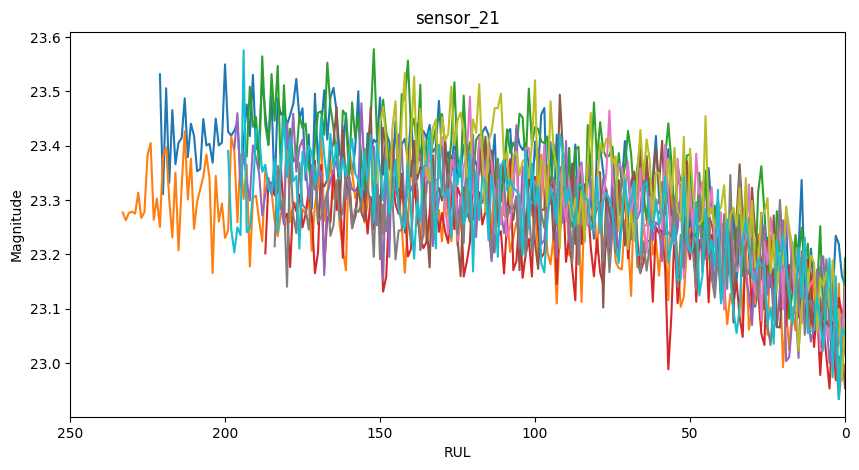

In [17]:
for i in ['sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']:
    plt.figure(figsize=(10,5))
    for j in xtrain['unit_number'].unique():
        if (j % 10 == 0):
            temp = xtrain[xtrain['unit_number']==j]
            plt.plot(temp['RUL'], temp[i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xlabel('RUL')
    plt.ylabel('Magnitude')
    plt.title(i)

##### Cox's Proportional Hazard Model
* A Cox model is a statistical technique that is used for survival-time (time-to-event) outcomes on one or more predictors.
* The response variable is the hazard function $h(t)$, which assesses the probability that the event of interest (in this case, jet engine failure) occurred before t. 
* The equation of Cox's hazard model is as follow:
$$
h(t) = h_0(t) \exp{(\sum_{k=1}^{n}\beta_k x_k)}
$$
Where,
* $h_0(t)$ : baseline hazard
* $\beta$  : regression coefficient of the covariate, x

In [18]:
# Initialize Cox's proportion hazard object
cph = CoxPHFitter(baseline_estimation_method="breslow")
# Fit the Cox's proportional hazard model
cph.fit(df=xtrain, duration_col = 'RUL', cluster_col = 'unit_number',formula="sensor_3+sensor_4+sensor_7+sensor_8+sensor_9+sensor_11+sensor_13+sensor_14+sensor_15+sensor_17+sensor_20+sensor_21")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 20631 total observations, 0 right-censored observations>
             duration col = 'RUL'
              cluster col = 'unit_number'
          robust variance = True
      baseline estimation = breslow
   number of observations = 20631
number of events observed = 20631
   partial log-likelihood = -173167.05
         time fit was run = 2023-08-30 01:10:00 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sensor_3    0.02       1.02       0.00             0.01             0.02                 1.01                 1.02
sensor_4    0.03       1.03       0.00             0.03             0.03                 1.03                 1.03
sensor_7   -0.24       0.79       0.03            -0.30            -0.18                 0.74                 0.84
sensor_8    1.56       4.78       0.43             0.73             2.40                 2.08                11.00
sensor_9    0.02       1.02       0.00             0.02             0.02                 1.02                 1.02
sensor_11   1.31       3.71       0.12             1.08             1.54                 2.95                 4.66
sensor_13   1.63       5.12       0.40             0.85             2.41                 2.35                11.16
sensor_14   0.02       1.02       0.00             0.01             0.02                 1.01                 1.02
sensor_15   4.76     116.71       0.45             3.87             5.65                48.04               283.51
sensor_17   0.07       1.07       0.01             0.05             0.09                 1.05                 1.09
sensor_20  -0.71       0.49       0.09            -0.89            -0.54                 0.41                 0.58
sensor_21  -1.40       0.25       0.13            -1.66            -1.14                 0.19                 0.32

            cmp to      z      p   -log2(p)
covariate                                  
sensor_3      0.00   8.06 <0.005      50.23
sensor_4      0.00  14.38 <0.005     153.44
sensor_7      0.00  -7.54 <0.005      44.28
sensor_8      0.00   3.68 <0.005      12.07
sensor_9      0.00  11.09 <0.005      92.48
sensor_11     0.00  11.25 <0.005      95.05
sensor_13     0.00   4.11 <0.005      14.61
sensor_14     0.00   7.71 <0.005      46.18
sensor_15     0.00  10.51 <0.005      83.41
sensor_17     0.00   6.13 <0.005      30.07
sensor_20     0.00  -8.19 <0.005      51.77
sensor_21     0.00 -10.45 <0.005      82.50
---
Concordance = 0.81
Partial AIC = 346358.11
log-likelihood ratio test = 22335.07 on 12 df
-log2(p) of ll-ratio test = inf

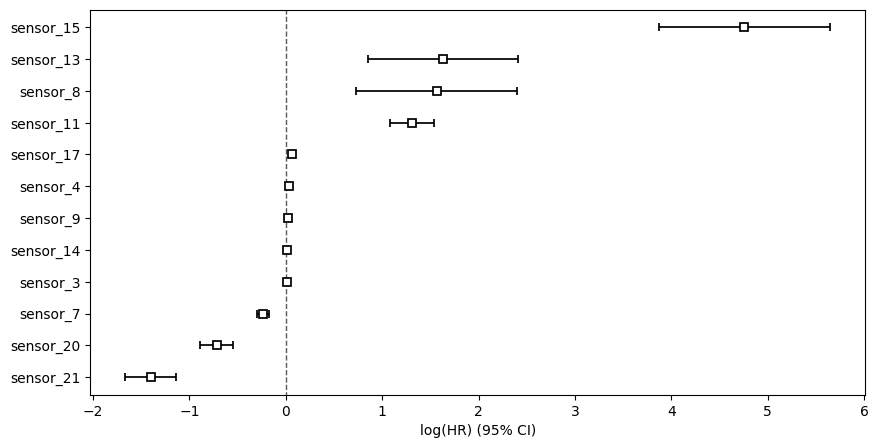

In [19]:
plt.figure(figsize=(10,5))
cph.plot()
plt.show()
plt.close()

##### Predict Hazard value
* The hazard value is the slope of the survival curve; i.e., it measures how rapidly engine units are failing.

In [20]:
predictions = cph.predict_log_partial_hazard(xtrain) #predict hazard value using training dataset
pred_test = cph.predict_log_partial_hazard(xtest) #predict hazard value using test dataset

predictions.rename("predictions", inplace=True)
predictions = predictions.to_frame()

pred_test.rename("predictions", inplace=True)
pred_test = pred_test.to_frame()

In [21]:
df_last = xtrain.groupby('unit_number').last()
predictions['RUL'] = xtrain['RUL'] # Add rul value of training dataset
pred_test['RUL'] = xtest['RUL'] # Add rul value of test dataset
predictions.head(10)

,predictions,RUL
0,-1.767545,191
1,-1.498317,190
2,-1.798477,189
3,-2.200110,188
4,-1.498908,187
5,-2.452552,186
6,-1.928499,185
7,-2.257546,184
8,-2.368942,183
9,-2.018412,182


* Compare the log partial hazard value with Remaining Useful Lifetime of training data
    * From the scatter plot, log partial hazard value increases as RUL decreases. Therefore, the graph explains about the risk of engine failure. 
    <br> <br>
    * Higher the hazard value, the more risk that engine units will break down.

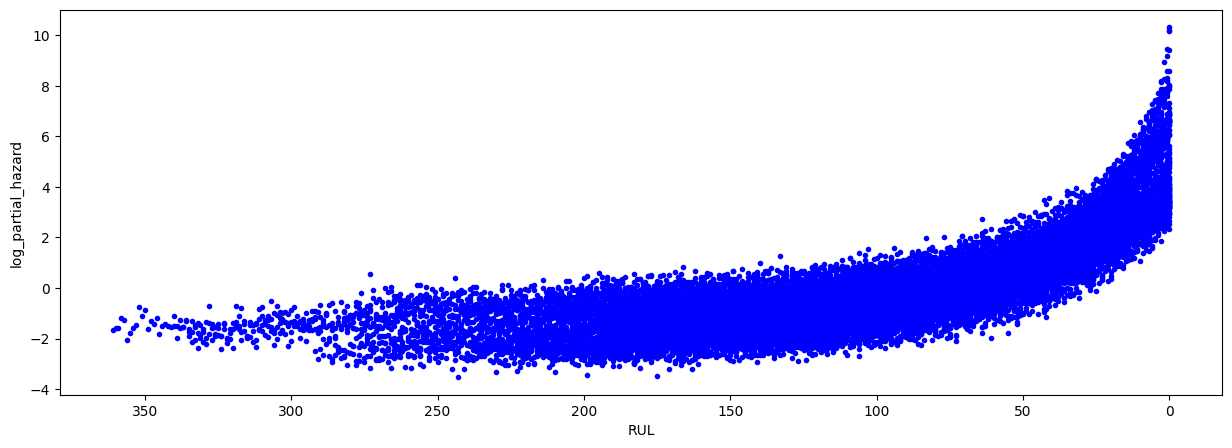

In [22]:
plt.figure(figsize=(15,5))
plt.plot(predictions['RUL'], predictions['predictions'], '.b')
xlim = plt.gca().get_xlim()
plt.xlim(xlim[1], xlim[0])
plt.xlabel('RUL')
plt.ylabel('log_partial_hazard')

plt.show()
plt.close()

* Plot log partial hazard value with time cycle.
    * The log partial hazard value increases as time cycle increases, meaning the risk of engine units failure increases over time.

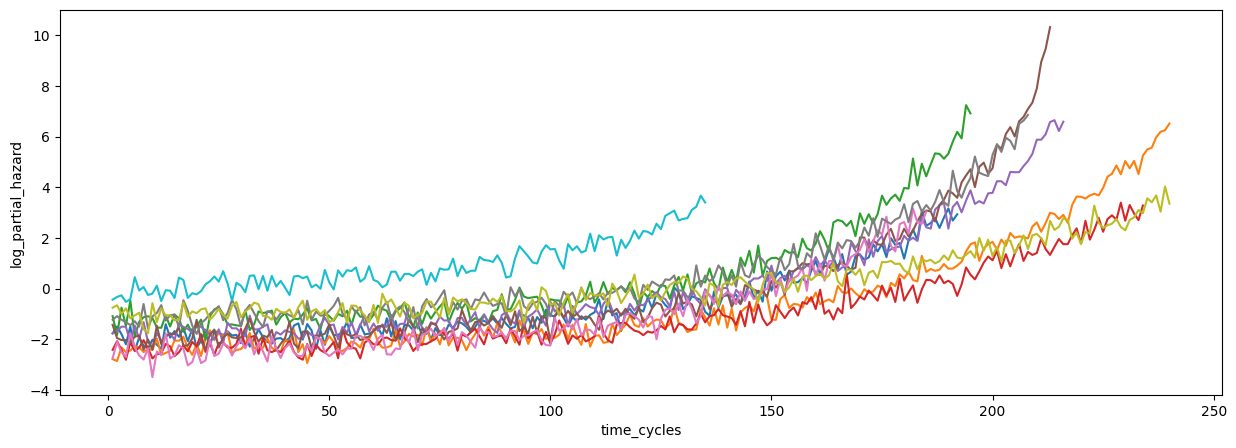

In [23]:
# Let's see how the hazard of the engines behave over time
# now lets look at some hazard trajectories
X_unique = len(xtrain['unit_number'].unique())

plt.figure(figsize=(15,5))

for i in range(1, X_unique, 10):
    X_sub = xtrain.loc[xtrain['unit_number'] == i]
    predictions = cph.predict_partial_hazard(X_sub).values
    plt.plot(X_sub['time_cycles'].values, np.log(predictions))

plt.xlabel('time_cycles')
plt.ylabel('log_partial_hazard')
plt.show()

In [34]:
df_train_hazard = xtrain.copy()
df_train_hazard['hazard'] = cph.predict_log_partial_hazard(df_train_hazard)

df_test_hazard = xtest.copy()
df_test_hazard['hazard'] = cph.predict_log_partial_hazard(df_test_hazard)
df_hazard.head()

,unit_number,setting_1,setting_2,setting_3,time_cycles,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL,hazard
0,1,-0.0007,-0.0004,100.0,1,1589.70,1400.60,554.36,2388.06,9046.19,47.47,2388.02,8138.62,8.4195,392,39.06,23.4190,191,-1.767545
1,1,0.0019,-0.0003,100.0,2,1591.82,1403.14,553.75,2388.04,9044.07,47.49,2388.07,8131.49,8.4318,392,39.00,23.4236,190,-1.498317
2,1,-0.0043,0.0003,100.0,3,1587.99,1404.20,554.26,2388.08,9052.94,47.27,2388.03,8133.23,8.4178,390,38.95,23.3442,189,-1.798477
3,1,0.0007,0.0000,100.0,4,1582.79,1401.87,554.45,2388.11,9049.48,47.13,2388.08,8133.83,8.3682,392,38.88,23.3739,188,-2.200110
4,1,-0.0019,-0.0002,100.0,5,1582.85,1406.22,554.00,2388.06,9055.15,47.28,2388.04,8133.80,8.4294,393,38.90,23.4044,187,-1.498908


##### Since the goal is to predict the Remaining Useful Lifetime (RUL) of the engine, now, let's plot RUL vs log partial hazard value
* From the figure, the relationship is non-linear and we can fit trajectory by using an exponential model.

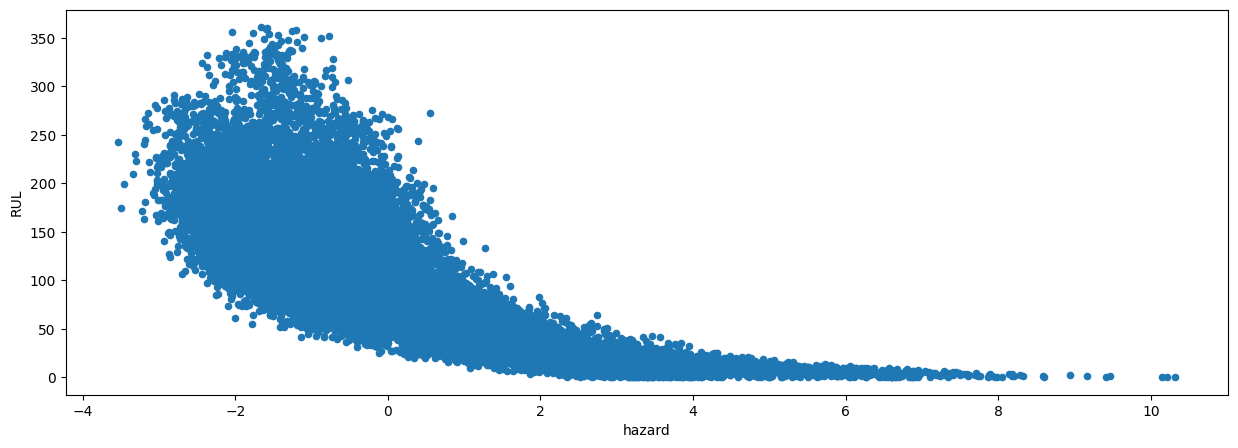

In [35]:
df_train_hazard.plot('hazard', 'RUL', 'scatter', figsize=(15,5))
plt.xlabel('hazard')
plt.ylabel('RUL')
plt.show()

##### Exponential model
* Exponential model can be defined as:
$$
\hat{y} = a e^{-bz}
$$
Where, 
* z       : partial hazard value estimated from Cox's survival analysis
* a and b : coefficients 

In [28]:
from scipy.optimize import curve_fit

def exponential_model(z, a, b):
    return a * np.exp(-b * z)

#### Example of how exponential fitting looks like
* Below figure shows visualization of exponential fit of RUL vs log partial hazard value by using only engine unit=1

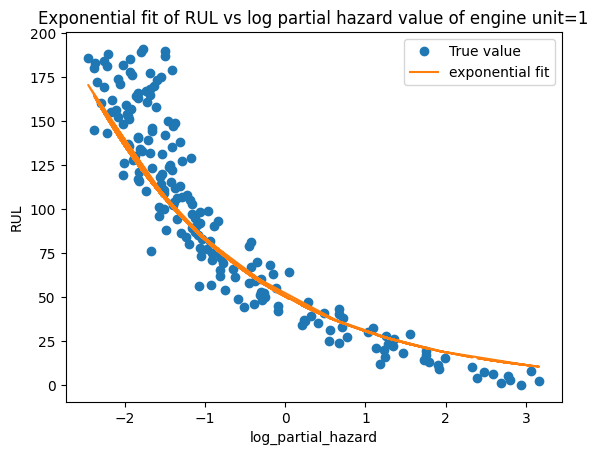

In [36]:
# check specific unit_nr
y_hat = exponential_model(df_train_hazard.loc[df_train_hazard['unit_number']==1, 'hazard'], 50, 0.5)

plt.plot(df_train_hazard.loc[df_train_hazard['unit_number']==1, 'hazard'], df_train_hazard.loc[df_train_hazard['unit_number']==1, 'RUL'], 'o',
        df_train_hazard.loc[df_train_hazard['unit_number']==1, 'hazard'], y_hat)
plt.xlabel("log_partial_hazard")
plt.ylabel("RUL")
plt.title('Exponential fit of RUL vs log partial hazard value of engine unit=1')
plt.legend(['True value', 'exponential fit'])
plt.show()
plt.close()

* Fit exponential curve by using training data

In [37]:
# fitting the exponential curve by using training data
popt, pcov = curve_fit(exponential_model, df_train_hazard['hazard'], df_train_hazard['RUL'])
popt  # the coefficients

array([95.71164593,  0.31283915])

In [38]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [39]:
# predict and evaluate of training dataset
y_hat = exponential_model(df_train_hazard['hazard'], *popt)
evaluate(df_train_hazard['RUL'], y_hat, 'train')

train set RMSE:44.65034403413153, R2:0.579784655477976


In [40]:
# predict and evaluate of test dataset
ytest_hat = exponential_model(df_test_hazard['hazard'], *popt)
evaluate(df_test_hazard['hazard'], ytest_hat, 'test')

test set RMSE:143.1336859759541, R2:-17470.564255287612


#### References
1. A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Prognostics Data Repository, NASA Ames Research Center, Moffett Field, CA

2. Great Learning Team. (2022, October 31). Survival Analysis: What is Kaplan-Meier Curve? Great Learning Blog: Free Resources What Matters to Shape Your Career! https://www.mygreatlearning.com/blog/kaplan-meier-curve-explained/#:~:text=The%20Kaplan%20Meier%20Curve%20is,at%20a%20respective%20time%20interval.

3. Hashim, D., & Weiderpass, E. (2017). Cancer Survival and Survivorship. In Encyclopedia of Cancer (Third Edition). https://doi.org/10.1016/b978-0-12-801238-3.65102-4

4. Robust nonlinear regression in scipy — SciPy Cookbook  documentation. (n.d.). https://scipy-cookbook.readthedocs.io/items/robust_regression.html

5. How to get a robust nonlinear regression fit using scipy.optimize.least_squares? (n.d.). Stack Overflow. https://stackoverflow.com/questions/52930401/how-to-get-a-robust-nonlinear-regression-fit-using-scipy-optimize-least-squares

6. Raoniar, R. (2022, May 6). Survival analysis in Python (KM Estimate, Cox-PH and AFT model). Medium. https://medium.com/the-researchers-guide/survival-analysis-in-python-km-estimate-cox-ph-and-aft-model-5533843c5d5d

7. Angell, Z. (2021, December 7). Modeling customer churn with survival analysis - Zach Angell - Medium. Medium. https://medium.com/@zachary.james.angell/applying-survival-analysis-to-customer-churn-40b5a809b05a

8. Kpeters. (n.d.). exploring-nasas-turbofan-dataset/4_FD001_Survival_analysis.ipynb at master · kpeters/exploring-nasas-turbofan-dataset. GitHub. https://github.com/kpeters/exploring-nasas-turbofan-dataset/blob/master/4_FD001_Survival_analysis.ipynb